Abhishek Choraria
https://www.linkedin.com/in/abhishek-choraria-b0966a67/


In [ ]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

# [1] load data

170498071/170498071 [==============================] - 11s 0us/step


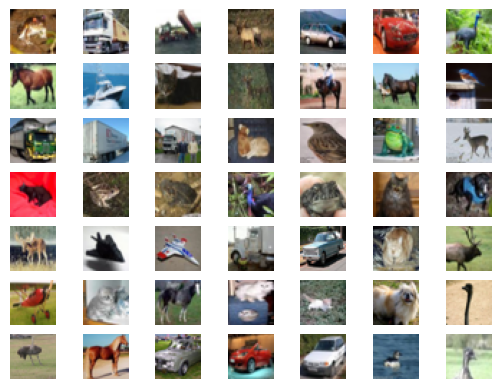

In [ ]:
(trainX,trainy),(testX,testy) = load_data()

# plot images from training dataset
for i in range(49):

  # define subplot
  pyplot.subplot(7,7,1+i)
  # turn off axis
  pyplot.axis('off')
  #plot raw pixel data
  pyplot.imshow(trainX[i])
pyplot.show()

In [ ]:
print(trainX.shape)

(50000, 32, 32, 3)


In [ ]:
# 50000 images of 32x32 with 3(RGB)

# [2] Build
- we have two things to build Discriminator and Generator.
- First build Discriminator(Simple neural netwrok to predict real or fake)
- BUild Generator
- Combine and make GAN
- Train

In [ ]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
import numpy as np


In [ ]:
# define discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  #normal
  # 64 filters of 3x3, padding shape same as input
  model.add(Conv2D(64,(3,3),padding = 'same',input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(256,(3,3), strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #Classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))
  #compile
  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


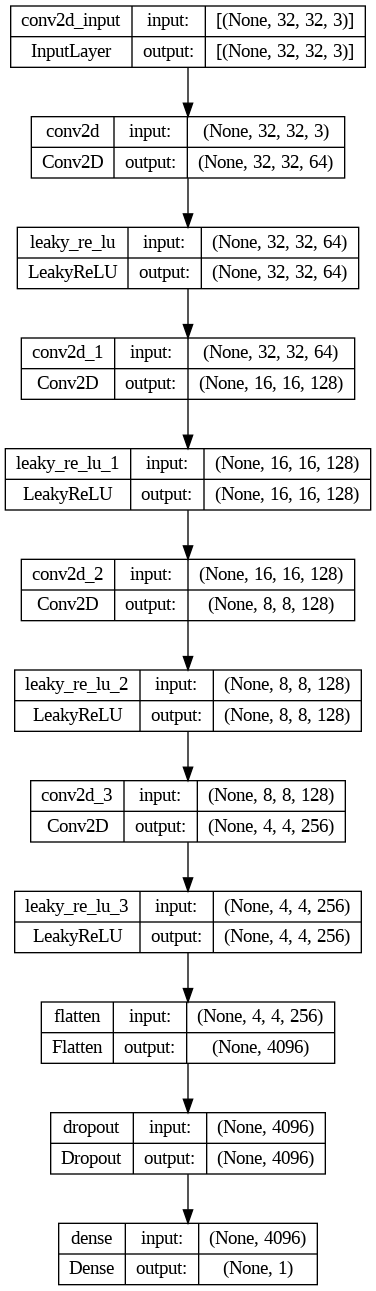

In [ ]:
#define model
model = define_discriminator()
## summarize the model
model.summary()
# plot the model
plot_model(model,to_file='discriminator_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
## lets see how it is trained
## it will get original data and random fake data
## we will assign what is random data and what is fake data
## we will train and  see accuracy

- Lets see how it is trained
- It will get original data and random fake data
- we will assign what is random data and what is fake data
- we will train and  see accuracy
- **We will define a function so that we can give both train data and test data**

In [ ]:
def load_real_samples():
  # load cifari10 dataset
  (trainX,_),(_,_) = load_data()
  #convert from unsigned int to floats
  X=trainX.astype('float32')
  #scale from [0,255] to [-1,1], because we are going ti use tanh in generator
  X = (X-127.5)/127.5
  return X


In [ ]:
# we get our real data using above function
X = load_real_samples()
X.shape

(50000, 32, 32, 3)

In [ ]:
## call first image
## all the values lie between -1 to 1
X[0]

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215687, -0.01960784, -0.2       ],
        [ 0.16078432, -0.02745098, -0.19215687]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980393, -0.5686275 ],
        [-0.06666667, -0.34901962, -0.60784316],
        [-0.04313726, -0.31764707, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.07450981, -0.34117648, -0.60784316],
        [-0.05882353, -0.34117648, -0.60784316],
        [-0.14509805, -0.42745098, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333334, -0.24705882],
        [ 0

- **when we train discriminator we will give images in batches, 64 real images and 64 fake images, it will process this and update weight according to that. Then we will give second batch of  images again and will update weights again**
- So we will define generator

In [ ]:
'''We deine a generator sample, we give dataset and tell how many samples we want
it will give some images with label'''
def generate_real_samples(dataset,n_samples):
  # chose random instances
  ix = np.random.randint(0,dataset.shape[0],n_samples)
  # retrieve selected images
  X =dataset[ix]
  # generate 'real' class labels (1)
  y = np.ones((n_samples,1))
  return X, y

In [ ]:
## give dataset X to function and get 64 images with labels
X,y = generate_real_samples(X,64)
print(X.shape)
print(y.shape)
# print(y)

(64, 32, 32, 3)
(64, 1)


In [ ]:
## generate fake samples
def generate_fake_samples(n_samples):
  # generate uniform random numbers in [0,1]
  X = np.random.rand(32*32*3*n_samples)
  # update to have the range [-1,1]
  x = -1 + X * 2
  # reshape into a batch of color images
  X = X.reshape((n_samples,32,32,3))
  # generate 'fake' class labels(0)
  y = np.zeros((n_samples,1))
  return X,y

In [ ]:
## generate fake sample of 64 images
X,y = generate_fake_samples(64)

(64, 32, 32, 3)
(64, 1)


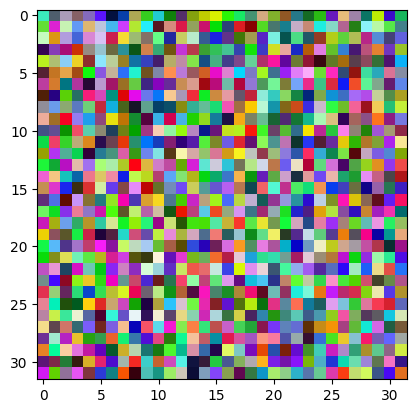

In [ ]:
print(X.shape)
print(y.shape)
# print(y)
## noise of image looks like
pyplot.imshow(X[0])

**Right now For discriminator its easy to learn this is fake ,because this noise is easily separable from actual image.
If the noise is generated by generator and generator keeps on learning to look like actual image . Then for discriminator
it will be really diifcult to understand which is real and which is fake**

We are going to **train the discriminator** on basis of real and fake images we created. Later on we will generate images with generator to train discriminator.

In [ ]:
# train the discriminator model temporarily
def train_discriminator(model,dataset,n_iter=20,n_batch=128):
  # half batch for 64 real images and 64 fake images
  half_batch = int(n_batch/2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected real samples
    X_real,y_real = generate_real_samples(dataset,half_batch)
    # update discriminator on 'real' samples
    _,real_acc = model.train_on_batch(X_real,y_real)
    # generate 'fake' samples
    X_fake,y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _,fake_acc = model.train_on_batch(X_fake,y_fake)
    # summarise performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1,real_acc*100, fake_acc*100))

In [ ]:
# Example Training

# define the discriminator model

model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model,dataset)

>1 real=59% fake=0%
>2 real=97% fake=11%
>3 real=95% fake=100%
>4 real=80% fake=100%
>5 real=77% fake=100%
>6 real=88% fake=100%
>7 real=84% fake=100%
>8 real=81% fake=100%
>9 real=78% fake=100%
>10 real=89% fake=100%
>11 real=88% fake=100%
>12 real=94% fake=100%
>13 real=94% fake=100%
>14 real=92% fake=100%
>15 real=94% fake=100%
>16 real=95% fake=100%
>17 real=97% fake=100%
>18 real=94% fake=100%
>19 real=97% fake=100%
>20 real=95% fake=100%


## Define **Generator**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose # used to upscale the data
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model


- Define generator standalone
- Generator is a neural network
- We need 32x32x3 image output
- we are going to give input as random .
- we are going to feed a 100 dimesnion vector , which would be randomly generated from gaussian distribution.
- The noise which we are goint to input noise is called latent variable.

**Building Generator**
- Gives **input of 100 dimension** also called as **latent dimension**
- First layer is dense layer of generator.
- We do upscaling to increase size of image and use Conv2D,Conv2D for that.
- As we reach the shape we want we apply conv2D layer.

**First Dense layer**
-- first dense layer(see explanation above)
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape(4,4,256))
- HOw many nodes in dense layer ?
- if we want output of 32*32*3 then no. of nofes should be atleast equal to 32*32,
or half of image size
16*16
or half of it
8*8
or
4*4
-With experimentation it has been proved that 4*4 is a good number to start with.
we will make 100 pictures of 4*4. we should have nodes for these pictures 1600 nodes.
- we are trying to create picture from latent dimension.
- Generator is trying to capture the representation(distribution) of the data(cifar10).
-- There can be multiple ditribution of data in same picture like color, face cut etc. we are trying to capture that in the 256 images.
- We apply Leaky Relu

**Conv2D transpose**
- we apply 3 layers of Conv2D to upscale the images.
model.addConv2DTranspose(128,(4,4),stride=(2,2),paddings = 'same')
- we use strides (2,2) which we will make image double to (8,8) from (4,4).
- we use strides (2,2) which we will make image double to (16,16) from (8,8).
- we use strides (2,2) which we will make image double to (32,32) from (16,16).

**Final output layer**
 - output layer
  model.add(Conv2D(3,(3,3),activation ='tanh',paddings='same'))
- so we use use just 3 filters of size (3,3). so we get 32 x 32 x 3 image.

- **So we gave an input of 100 dimension and we finally get an image of 32x32x3**

In [ ]:
# ## define generator standalone

# - We need 32x32x3 image output
# - we are going to give input as random .
# - we are going to feed a 100 dimesnion vector , which would be randomly generated from gaussian distribution.
# - The noise which we are goint to input noise is called latent variable
# -

In [ ]:
from keras.layers.reshaping.reshape import Reshape
# define standalone generator model.
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  # first dense layer(see explanation above)
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  ## upsample to 8x8
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))
  ##upsample to 16x16
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))
  ##upsample to 32x32
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))
  #output layer
  model.add(Conv2D(3,(3,3),activation ='tanh',padding='same'))
  return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

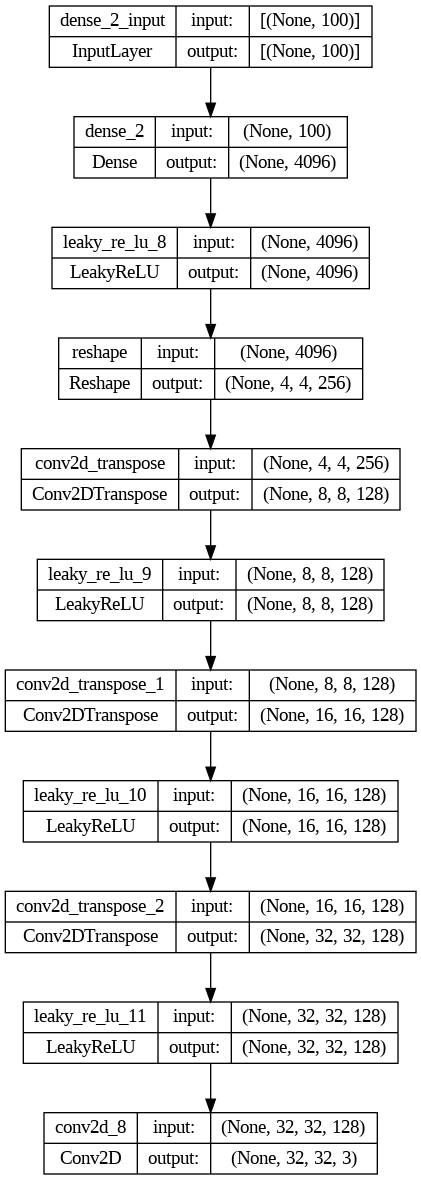

In [ ]:
## define the size of latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file = 'generator_plot.png',show_shapes=True,show_layer_names=True)

**My generator is not trained yet as we are not getting any feedback from discriminator**
- Generator has to improve itself and has to give images to data.
**How much images generator will generate**
 Generator will generate images on basis of how many images it has to give Discriminator.
How many images discriminator needs from generator ?
The same amount of images it gets from real data.
- So Generator will generate multiple images.
- Lets say batch size is 128, discriminator will take 128 images, 64 from generator , 64 from discriminator, after that it will update its weights.

 **We going to write a code which will gives us the number of images(64 in this case) we want to generate**

In [ ]:
# generate points in latent space as input for generator
# no. of samples(rows) we want for what dimensions(columns)
def generate_latent_points(latent_dim,n_samples):
  # generate points in latent space for n_samples of dimension
  x_input = np.random.randn(latent_dim*n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples,latent_dim)
  return x_input

In [ ]:
x_input = generate_latent_points(100,64)
print(x_input.shape)

(64, 100)


- **- We gave generator 64 ,100 dimensional points and it returns 64 images of 32*32*3**
- These 64 images of data we are going to give it to discriminator with 64 real images.






**In above code generate_fake_samples we generated fake samples using numpy but the code should be generated using generator itself.
We going to Generate fake samples using generator with class label**


- We give inputs as model name, latent dimensions, number of samples.
- generate latent points using above func.
- use generator model to predict output(generate images) from the input of latent dimension.
-- if input is of shape (64,100) output will be 32*32*3. We are giving 64 points as input of 100 dimensions. it will return 64 images.

In [ ]:
# use generator to generate n fake samples, with class labels
## generator model, of how many dimensions, of what shape
def generate_fake_samples(g_model,latent_dim,n_samples):
  #generate points in latent space
  x_input = generate_latent_points(latent_dim,n_samples)
  #predict outputs
  x = g_model.predict(x_input)
  # create 'fake' class labels (0)
  y = np.zeros((n_samples,1))
  return X,y

**Visualize the fake samples generated**

2/2 [==============================] - 1s 157ms/step


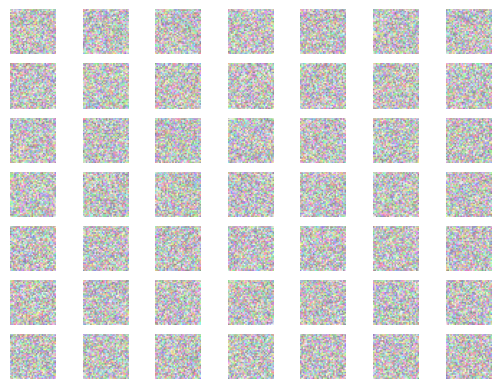

In [ ]:
# size of latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X,_=generate_fake_samples(model,latent_dim,n_samples)
# scale pixel values from [-1,1] to [0,1]
X= (X+1)/2.0
#plot the generated samples
for i in range(n_samples):
  #deine subplot
  pyplot.subplot(7,7,1+i)
  #turn off axis labels
  pyplot.axis('off')
  # plot single image
  pyplot.imshow(X[i])
#show the figure
pyplot.show()

## **Final Step**

- We are going to merge the Discriminator and Generator to train Generator to generate more real images, Discriminator to be able to predict the real ,fake.

- We are going to make a composite model

- ***Create a new Sequential model,
   - **Freeze trainining of
      Discriminator**
     -- All layers of Discriminator will be frozen, When we update the weights according to loss it will update the weights of only Generator not discriminator  
   -Add generator,
     -- Image output from generator will be given as 1.
     -- Because lets say discriminator has learned very well, now we are trying to fool the discriminator that this is real image input as 1 , but discriminator will say no this fake image as output zero. it will try to minimise the loss,
     it will backpropagate to update the weights of generator to generate more real images, Discriminator weights will not be updated as they are frozen.Now the generator will learn more from data in such a way that it will generate images which are closer to actual data. Weights of input noise will be adjusted in a way that it will generate real images.
   -Add discriminator,
   -optimizer - Adam
   -Compile the model***

**How Did discriminator learned that it is real or fake data**
- We train discriminator alone with real data and fake data from generator.

- Lets say we use 200 epochs to train.
- Each epochs will 128 batches, 64 real images, 64 fake images(generated by generator).
- In first step we will train discriminator on 64 real images and update weight, 64 fake images and update weight. So in one epoch in one batch data, discriminator will update weight two times.
- So when discriminator is predicting weights of genrator will not be updated, when generator is generating images, weights of discriminator will not be updated.
- In epoch 1 discriminator and generator doesnt know much. Discriminator learned a bit to predict real ,fake images.and then generator aslo learned a bit to make better images. So both of them are trained simultanelously in one epoch, and epoch by epoch.
- In every epoch first weight of dicriminator will be updated 2 times, then weight of generator will be updated one time.


In [ ]:
# define the combined generator and discriminator model for updating the generator.
def define_gan(g_model,d_model):
  #make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  #add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile the model
  opt = Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 32, 32, 3)         1466115   
                                                                 
 sequential_9 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


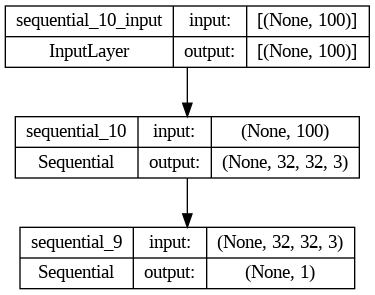

In [ ]:
# size of latent space
latent_dim = 100
# create the dicriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model,d_model)
# summarize gan model
gan_model.summary()
# plot glan model
plot_model(gan_model,to_file='gan_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
# train generator and discriminator
def train(g_model,d_model,dataset,latent_dim,n_epochs=200,n_batch=128):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected samples
      x_real,y_real = generate_real_samples(dataset,half_batch)
      # update the discriminator weight
      d_loss1,_ = d_model.train_on_batch(x_real,y_real)
      #generate 'fake' examples
      x_fake, y_fake= generate_fake_samples(g_model,latent_dim,half_batch)
      #update discriminator model weights
      d_loss2,_= d_model.train_on_batch(x_fake,y_fake)
      #prepare points in latent space as input for generator
      x_gan = generate_latent_points(latent_dim,n_batch)
      # create imported labels for the samples.
      y_gan = np.ones((n_batch,1))
      #update the generator via the discriminators error
      g_loss=gan_model.train_on_batch(x_gan,y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d ,d1=%.3f, d3=%.3f g=%.3f' %
            (i+1,j+1,bat_per_epo,d_loss1,d_loss2,g_loss))
      #evaluate the model perfromance sometimes
      if (i+1)%10==0:
        summarize_performance(i,g_model,d_model,dataset,latent_dim)



In [ ]:
#evaluate the discriminator , plot generated images, save generated model
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=150):
  #prepare real samples
  x_real,y_real = generate_real_samples(dataset,n_samples)
  # evaluate discriminator on real examples
  _,acc_real = d_model.evaluate(x_real,y_real,verbose=0)
  #prepare fake examples
  x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
  #evaluate discriminator on fake samples
  _,acc_fake = d_model.evaluate(x_fake,y_fake,verbose=0)
  # summarise discriminator perdormance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' %
        (acc_real*100, acc_fake*100))
  #save plot
  save_plot(x_fake,epoch)
  #save the generator model title file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [ ]:
#create and a plot of generated images
def save_plot(examples,epoch, n=7):
  #scale from [-1,1] to [0,1]
  examples = (examples +1)/2.0
  # plot images
  for i in range(n * n):
    pyplot.subplot(n,n,i+i)
    # turn off axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(examples[i])
  #save plot to file
  filename = 'generate_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

In [ ]:
train(g_model,d_model,dataset,latent_dim,n_epochs=200,n_batch=128)

2/2 [==============================] - 1s 257ms/step
>1, 1/390 ,d1=0.620, d3=0.532 g=0.672
2/2 [==============================] - 1s 260ms/step
>1, 2/390 ,d1=0.556, d3=0.418 g=0.637
2/2 [==============================] - 1s 275ms/step
>1, 3/390 ,d1=0.512, d3=0.290 g=0.556
2/2 [==============================] - 1s 265ms/step
>1, 4/390 ,d1=0.433, d3=0.162 g=0.389
2/2 [==============================] - 1s 329ms/step
>1, 5/390 ,d1=0.385, d3=0.098 g=0.163
2/2 [==============================] - 1s 264ms/step
>1, 6/390 ,d1=0.289, d3=0.073 g=0.025
2/2 [==============================] - 1s 413ms/step
>1, 7/390 ,d1=0.249, d3=0.060 g=0.003
2/2 [==============================] - 1s 262ms/step
>1, 8/390 ,d1=0.246, d3=0.065 g=0.000
2/2 [==============================] - 1s 390ms/step
>1, 9/390 ,d1=0.126, d3=0.061 g=0.000
2/2 [==============================] - 1s 255ms/step
>1, 10/390 ,d1=0.135, d3=0.053 g=0.000
2/2 [==============================] - 1s 254ms/step
>1, 11/390 ,d1=0.069, d3=0.040 g=0.0